In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import torchvision

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dados_treinamento = pd.read_table('D:/Dados/Desktop/R/Kaggle - Digit Recognizer/train.csv', sep=',')
dados_teste = pd.read_table('D:/Dados/Desktop/R/Kaggle - Digit Recognizer/test.csv', sep=',')

In [3]:
treinamento = dados_treinamento.drop(labels = ['label'], axis = 1)
treinamento = np.array(treinamento, dtype = np.float32)
teste = np.array(dados_teste, dtype = np.float32)
labels_treinamento = dados_treinamento['label']
labels_treinamento = np.array(labels_treinamento)

In [4]:
treinamento = treinamento.reshape(-1, 28, 28, 1)
labels_treinamento = labels_treinamento.reshape(-1, 1)
teste = teste.reshape(-1, 28, 28, 1)

In [5]:
treinamento = treinamento / 255.0
teste = teste / 255.0

In [6]:
Y_train = to_categorical(labels_treinamento, num_classes = 10)

Label:  [3] Categórigo:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


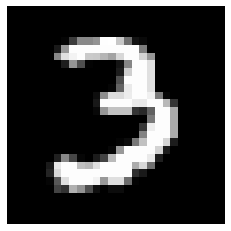

In [42]:
label_exemplo = 9

print('Label: ', labels_treinamento[label_exemplo], 'Categórigo: ', Y_train[label_exemplo])
plt.imshow(treinamento[label_exemplo].reshape(28,28), cmap = 'gray')
plt.axis('off')
plt.show()

In [46]:
#print(treinamento[7].reshape(28,28))
#treinamento[9].reshape(28,28)
#treinamento[13].reshape(28,28)

In [6]:
class DataSetTreinamento(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        if len(self.X) != len(self.Y):
            raise Exception("O tamanho de X não é igual ao tamanho de Y")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _x = self.X[index]
        _y = self.Y[index]

        return _x, _y

In [7]:
loader = DataLoader(DataSetTreinamento(treinamento.reshape(42000, 1, 28, 28), labels_treinamento), batch_size=50)
batch = next(iter(loader))
images, labels = batch

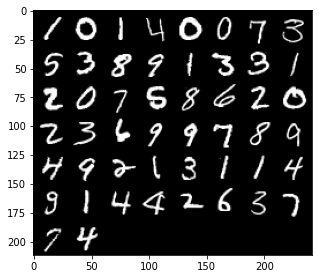

In [13]:
grid = torchvision.utils.make_grid(images, n_row = 10)

plt.figure(figsize=(5,5))
plt.imshow(np.transpose(torch.FloatTensor(grid), (1,2,0)))
plt.show()

In [7]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)

In [13]:
## 200000 imagens pegando amostras aleatorias de 'treinamento'
imagens_extras = []
labels_imagens_extras = []
img_nova = []
label_img_nova = []

for i in range(200000):
    indice_rand = np.random.randint(0,42000,1)
    X_train = treinamento[indice_rand].reshape(1,28,28,1)
    label_img_nova = labels_treinamento[indice_rand]
        
    X_train2, Y_train2 = datagen.flow(X_train,label_img_nova).next()
    imagens_extras.append(X_train2)
    labels_imagens_extras.append(Y_train2)


In [8]:
## Gerando 10 variacoes de todas as imagens de 'treinamento'
imagens_extras = []
labels_imagens_extras = []
img_nova = []
label_img_nova = []

for j in range(len(treinamento)):
    for i in range(10):
        X_train = treinamento[j].reshape(1,28,28,1)
        label_img_nova = labels_treinamento[j]
            
        X_train2, Y_train2 = datagen.flow(X_train,label_img_nova).next()
        imagens_extras.append(X_train2)
        labels_imagens_extras.append(Y_train2)

In [9]:
imagens_extras = np.array(imagens_extras)
labels_imagens_extras = np.array(labels_imagens_extras)

In [10]:
labels_imagens_extras = labels_imagens_extras.reshape(-1)

2


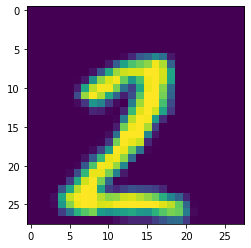

In [11]:
a = 400000
plt.imshow(imagens_extras[a].reshape(28,28))
print(labels_imagens_extras[a])

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (3,3))
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = (3,3))
        self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = (3,3))

        self.fc1 = nn.Linear(in_features = 24*4*4, out_features = 256)
        self.norm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 120)
        self.out = nn.Linear(in_features = 120, out_features = 10)
        
    def forward(self, t):
        
        # Conv 1
 #       print('entrada: ', t.shape)
        t = F.relu(self.conv1(t))
  #      print('conv1: ', t.shape)
        t = F.max_pool2d(t, kernel_size = (2,2), stride = 2)
 #       print('pool1: ', t.shape)

        # Conv 2
        t = F.relu(self.conv2(t))
 #       print(t.shape)
        t = F.max_pool2d(t, kernel_size = (2,2), stride = 1)
 #       print(t.shape)

        # Conv 3
        t = F.relu(self.conv3(t))
 #       print(t.shape)
        t = F.max_pool2d(t, kernel_size = (2,2), stride = 2)
 #       print(t.shape)

        t = t.reshape(-1, 24*4*4)
        
        t = F.relu(self.fc1(t))
        t = F.relu(self.norm1(t))
        t = F.relu(self.fc2(t))
   #     t = F.relu(self.fc3(t))
        t = self.out(t)
        
        return t

In [14]:
tb = SummaryWriter()

a = Network()
#a(torch.Tensor(5,1,28,28))
tb.add_image('images', grid)
tb.add_graph(a, images)

tb.close()

In [40]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(1, 3, 5),
            nn.Flatten(),
            nn.Linear(3 * 24 * 24, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )
        
    def forward(self, t):         
        return self.layers(t)

In [12]:
def numero_predicoes_corretas(preds, labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

In [13]:
imagens_extras = torch.Tensor(imagens_extras.reshape(len(imagens_extras), 1, 28, 28))

In [14]:
total_imagens = torch.cat((torch.Tensor(treinamento).reshape(42000, 1, 28, 28), imagens_extras))
total_labels = torch.cat((torch.LongTensor(labels_treinamento), torch.LongTensor(labels_imagens_extras.reshape(len(labels_imagens_extras), 1))))

tensor([7])

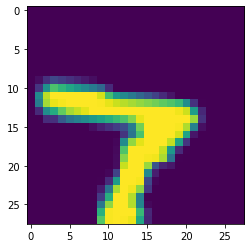

In [17]:
plt.imshow(total_imagens[100000].reshape(28,28))
total_labels[100000]

In [15]:
x_treino, x_val, y_treino, y_val = train_test_split(total_imagens, total_labels, test_size = 0.1, random_state = 33)

In [16]:
x_treino.shape, x_val.shape, y_treino.shape, y_val.shape

(torch.Size([415800, 1, 28, 28]),
 torch.Size([46200, 1, 28, 28]),
 torch.Size([415800, 1]),
 torch.Size([46200, 1]))

In [18]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr = 0.001, amsgrad = True)
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = .9, nesterov = True)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.6, patience = 4, verbose = True, min_lr = 1e-5)
scheduler2 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lambda epoch: .95)
scheduler3 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [25, 32], gamma = .7)
loader = DataLoader(DataSetTreinamento(x_treino, y_treino), batch_size = 64, shuffle=True)

torch.set_grad_enabled(True)
for epoch in range(35):
    
    total_loss = 0
    total_correct = 0
    
    for batch in loader:
        images, labels = batch

        optimizer.zero_grad()
        
        preds = model(images)
        loss = F.cross_entropy(preds, labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        
        total_loss += loss.item()
        total_correct += numero_predicoes_corretas(preds, labels.reshape(-1))

    scheduler1.step(loss)
    #scheduler2.step()
    scheduler3.step()

    pred_validacao = model(x_val)
    acertos_validacao = numero_predicoes_corretas(pred_validacao, y_val.reshape(-1))
             
    print('Época: ', epoch+1, ' |  Acertos Teste: ', total_correct, ' / ', len(x_treino), ' |  Acurácia Teste: ',
          total_correct/len(x_treino), ' |  loss: ', total_loss, ' |  Acurácia Validação: ', acertos_validacao / len(x_val))     

C:\Users\Bernardo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Época:  1  |  Acertos Teste:  402061  /  415800  |  Acurácia Teste:  0.9669576719576719  |  loss:  706.8194408876589  |  Acurácia Validação:  0.9845887445887446


KeyboardInterrupt: 

In [58]:
## Teste com GPU

model = Network()
if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.001, amsgrad = True)
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = .9, nesterov = True)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.6, patience = 4, verbose = True, min_lr = 1e-5)
scheduler2 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lambda epoch: .95)
scheduler3 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [25, 32], gamma = .7)
loader = DataLoader(DataSetTreinamento(x_treino, y_treino), batch_size = 64, shuffle = True)
val_loader = DataLoader(DataSetTreinamento(x_val, y_val), batch_size = 64, shuffle = True)

torch.set_grad_enabled(True)
for epoch in range(35):
    
    total_loss = 0
    total_correct = 0
    
    model.train()
    for batch in loader:
        images, labels = batch
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        
        preds = model(images)
        loss = F.cross_entropy(preds, labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += numero_predicoes_corretas(preds, labels.reshape(-1))

    val_loss = 0
    val_correct = 0
    model.eval()
    for val_batch in val_loader: 
        val_images, val_labels = val_batch
        if torch.cuda.is_available():
            val_images, val_labels = val_images.cuda(), val_labels.cuda()

        pred_validacao = model(val_images)
        loss = F.cross_entropy(pred_validacao, val_labels.reshape(-1))
        val_correct += numero_predicoes_corretas(pred_validacao, val_labels.reshape(-1))

        val_loss += loss.item()

    scheduler1.step(loss)
    scheduler2.step()
    scheduler3.step()

             
    print('Época: ', epoch+1, ' |  Acertos Teste: ', total_correct, ' / ', len(x_treino), ' |  Acurácia Teste: ',
          total_correct/len(x_treino), ' |  loss: ', total_loss, ' |  Acurácia Validação: ', val_correct / len(x_val), " |  loss val: ", val_loss)     

Época:  1  |  Acertos Teste:  404222  /  415800  |  Acurácia Teste:  0.9721548821548821  |  loss:  586.8255385115044  |  Acurácia Validação:  0.9833549783549783  |  loss val:  38.629773014748935
Época:  2  |  Acertos Teste:  410908  /  415800  |  Acurácia Teste:  0.9882347282347282  |  loss:  241.54253162516397  |  Acurácia Validação:  0.9912337662337662  |  loss val:  20.805790394486394
Época:  3  |  Acertos Teste:  412284  /  415800  |  Acurácia Teste:  0.9915440115440115  |  loss:  172.99643434376048  |  Acurácia Validação:  0.9914069264069264  |  loss val:  19.91347423347179
Época:  4  |  Acertos Teste:  412955  /  415800  |  Acurácia Teste:  0.9931577681577681  |  loss:  139.55438556372246  |  Acurácia Validação:  0.9926839826839827  |  loss val:  17.518159555111197
Época:  5  |  Acertos Teste:  413354  /  415800  |  Acurácia Teste:  0.9941173641173641  |  loss:  115.48285058889451  |  Acurácia Validação:  0.9934848484848485  |  loss val:  14.972574746454484
Época:  6  |  Acertos 

In [59]:
predicoes = model(torch.Tensor(teste).reshape(28000, 1, 28, 28)).argmax(dim = 1)

In [28]:
# Referência
predicoes[:10]

[2, 0, 9, 0, 3, 7, 0, 3, 0, 3]

In [60]:
# Previsto
predicoes[:10]

tensor([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

tensor(0)

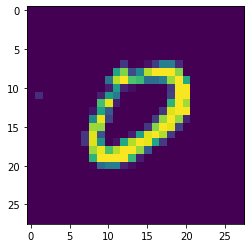

In [61]:
plt.imshow(teste[3].reshape(28,28))
predicoes[3]

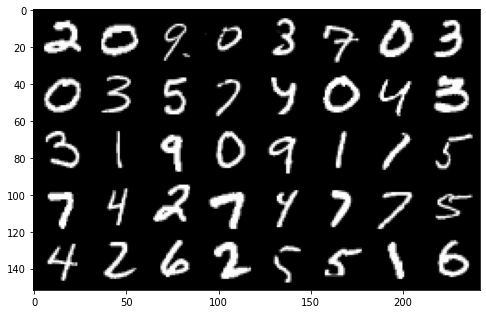

[[2 0 9 0 3 7 0 3]
 [0 3 5 7 4 0 4 3]
 [3 1 9 0 9 1 1 5]
 [7 4 2 7 4 7 7 5]
 [4 2 6 2 5 5 1 6]]


In [62]:
loader_teste = DataLoader(DataSetTreinamento(teste.reshape(28000, 1, 28, 28), np.arange(len(teste))), batch_size=40)
batch = next(iter(loader_teste))
images, labels = batch
grid = torchvision.utils.make_grid(images, n_row = 10)

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(torch.FloatTensor(grid), (1,2,0)))
plt.show()

print(np.array(predicoes[0:40]).reshape(5,8))

In [63]:
resultados = pd.Series(np.array(predicoes), name = 'Label')

In [64]:
submissao = pd.concat([pd.Series(range(1,28001),name = "ImageId"), resultados],axis = 1)

In [65]:
submissao.to_csv('D:/Dados/Desktop/R/Kaggle - Digit Recognizer/submissao_torch.csv',index=False)

In [66]:
torch.save(model, 'modelo_99357.pth')

In [ ]:
##    model = torch.load('modelo_99357.pth')

In [34]:
val_labels

tensor([[5],
        [5],
        [7],
        [1],
        [8],
        [3],
        [1],
        [5],
        [1],
        [4],
        [9],
        [1],
        [0],
        [3],
        [2],
        [7],
        [8],
        [5],
        [6],
        [1],
        [7],
        [1],
        [7],
        [7],
        [4],
        [8],
        [6],
        [1],
        [7],
        [7],
        [0],
        [2],
        [8],
        [9],
        [3],
        [9],
        [7],
        [9],
        [3],
        [2],
        [5],
        [3],
        [2],
        [1],
        [4],
        [6],
        [9],
        [6],
        [4],
        [0],
        [7],
        [0],
        [1],
        [3],
        [9],
        [1]])